In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, round, countDistinct, max, variance

In [2]:
spark = SparkSession.builder \
    .appName("DataPreprocessing") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/12 21:11:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/12 21:11:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/12 21:11:32 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [48]:
df = spark.read.csv("../DataSet/Prescribers - by Provider and Drug/MUP_DPR_RY23_P04_V10_DY21_NPIBN.csv", header=True, inferSchema=True)


In [49]:
print(df.columns)

['Prscrbr_NPI', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name', 'Prscrbr_City', 'Prscrbr_State_Abrvtn', 'Prscrbr_State_FIPS', 'Prscrbr_Type', 'Prscrbr_Type_Src', 'Brnd_Name', 'Gnrc_Name', 'Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst', 'Tot_Benes', 'GE65_Sprsn_Flag', 'GE65_Tot_Clms', 'GE65_Tot_30day_Fills', 'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Bene_Sprsn_Flag', 'GE65_Tot_Benes']


In [56]:
#Total Claims made by State of Prescribers
claims_by_state = (df.groupBy("Prscrbr_State_Abrvtn")
             .agg(round(sum("Tot_Clms") / 1e6, 0).alias("total_claim_millions"))
             .orderBy(col("total_claim_millions").desc()))

claims_by_state.show()

+--------------------+--------------------+
|Prscrbr_State_Abrvtn|total_claim_millions|
+--------------------+--------------------+
|                  CA|               117.0|
|                  FL|                99.0|
|                  TX|                84.0|
|                  NY|                83.0|
|                  PA|                64.0|
|                  OH|                55.0|
|                  NC|                46.0|
|                  IL|                44.0|
|                  MI|                43.0|
|                  GA|                41.0|
|                  TN|                35.0|
|                  MO|                32.0|
|                  NJ|                31.0|
|                  IN|                30.0|
|                  MA|                29.0|
|                  PR|                27.0|
|                  VA|                26.0|
|                  KY|                26.0|
|                  AL|                25.0|
|                  WI|          

In [57]:
# Collect data as a list of dictionaries
collected_data = claims_by_state.collect()
data_dict = [row.asDict() for row in collected_data]

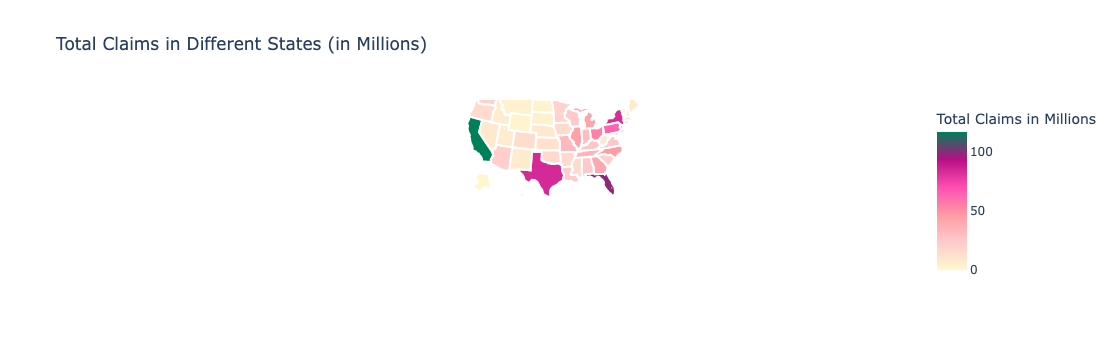

In [58]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Color scale for the choropleth map
scl = [
    [0.0, 'rgb(255,248,206)'], [0.2, 'rgb(255,203,205)'],
    [0.4, 'rgb(255,155,164)'], [0.6, 'rgb(255,79,178)'],
    [0.8, 'rgb(183,15,132)'], [1, '#008059']
]

# Creating the data for the map
data = [
    dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale=False,
        locations=[d['Prscrbr_State_Abrvtn'] for d in data_dict],
        z=[d['total_claim_millions'] for d in data_dict],
        locationmode='USA-states',
        text=[d['Prscrbr_State_Abrvtn'] for d in data_dict],
        marker=dict(
            line=dict(color='rgb(255,255,255)', width=2)
        ),
        colorbar=dict(title="Total Claims in Millions")
    )
]

# Layout for the map
layout = dict(
    title='Total Claims in Different States (in Millions)',
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

# Generating the figure
fig = dict(data=data, layout=layout)

# Plotting the figure
iplot(fig, filename='d3-cloropleth-map')

In [59]:
#Total Costs by Drugs
drug_cost = (df.groupBy("Brnd_Name")
             .agg(round(sum("Tot_Drug_Cst") / 1e6, 0).alias("total_drug_cost_millions"))
             .orderBy(col("total_drug_cost_millions").desc())
             .limit(30))

drug_cost.show()


+----------------+------------------------+
|       Brnd_Name|total_drug_cost_millions|
+----------------+------------------------+
|         Eliquis|                 11900.0|
|        Revlimid|                  5574.0|
|         Xarelto|                  4581.0|
|       Trulicity|                  4156.0|
|         Januvia|                  3532.0|
|       Jardiance|                  3187.0|
|       Imbruvica|                  2884.0|
|  Humira(Cf) Pen|                  2523.0|
| Lantus Solostar|                  2480.0|
|         Ozempic|                  2206.0|
| Trelegy Ellipta|                  2101.0|
|          Xtandi|                  2094.0|
|        Biktarvy|                  2064.0|
|       Myrbetriq|                  1680.0|
|       Symbicort|                  1628.0|
|         Ibrance|                  1618.0|
|        Entresto|                  1456.0|
|        Restasis|                  1434.0|
| Novolog Flexpen|                  1412.0|
|Enbrel Sureclick|              

In [61]:
top_30_drugCost = drug_cost.collect();
y = [row['Brnd_Name'] for row in reversed(top_30_drugCost)]
x = [row['total_drug_cost_millions'] for row in reversed(top_30_drugCost)]


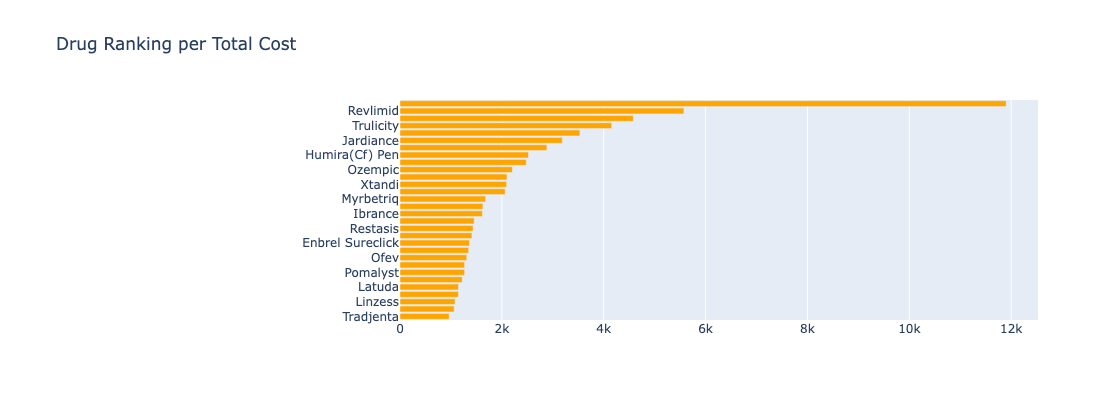

In [74]:
trace1 = go.Bar(x=x, y=y, orientation="h", marker=dict(color='orange'))
layout = dict(height=400, width=700, margin=dict(l=400), title='Drug Ranking per Total Cost')
data = [trace1]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')


In [76]:
total_state_claim_drug = (df.groupBy(col("Prscrbr_State_Abrvtn").alias("state"))
             .agg(countDistinct("Prscrbr_NPI").alias("npi_id"),
                  round(sum("Tot_Clms") / 1e6, 0).alias("total_claim_count_millions"),
                  round(sum("Tot_Day_Suply") / 1e6, 0).alias("total_day_supply_millions"),
                  round(sum("Tot_Drug_Cst") / 1e6, 0).alias("total_drug_cost_millions"))
             .orderBy(col("total_claim_count_millions").desc()))

total_state_claim_drug.show();


+-----+------+--------------------------+-------------------------+------------------------+
|state|npi_id|total_claim_count_millions|total_day_supply_millions|total_drug_cost_millions|
+-----+------+--------------------------+-------------------------+------------------------+
|   CA|103152|                     117.0|                   6329.0|                 16135.0|
|   FL| 67241|                      99.0|                   5390.0|                 12152.0|
|   TX| 65299|                      84.0|                   4551.0|                 11338.0|
|   NY| 72438|                      83.0|                   4083.0|                 13384.0|
|   PA| 47946|                      64.0|                   3169.0|                  8187.0|
|   OH| 40242|                      55.0|                   2779.0|                  6695.0|
|   NC| 33095|                      46.0|                   2326.0|                  5952.0|
|   IL| 38506|                      44.0|                   2347.0|   

In [77]:
# Count the number of rows in the resulting DataFrame
row_count = total_state_claim_drug.count()
print("Row count:", row_count)

Row count: 61


In [79]:
plot_tscd = total_state_claim_drug.select(
    "total_day_supply_millions", 
    "total_drug_cost_millions", 
    "total_claim_count_millions", 
    "state"
).collect()

# Preparing data for Plotly
x = [row['total_day_supply_millions'] for row in plot_tscd]
y = [row['total_drug_cost_millions'] for row in plot_tscd]
text = [row['state'] for row in plot_tscd]
size = [row['total_claim_count_millions'] for row in plot_tscd]


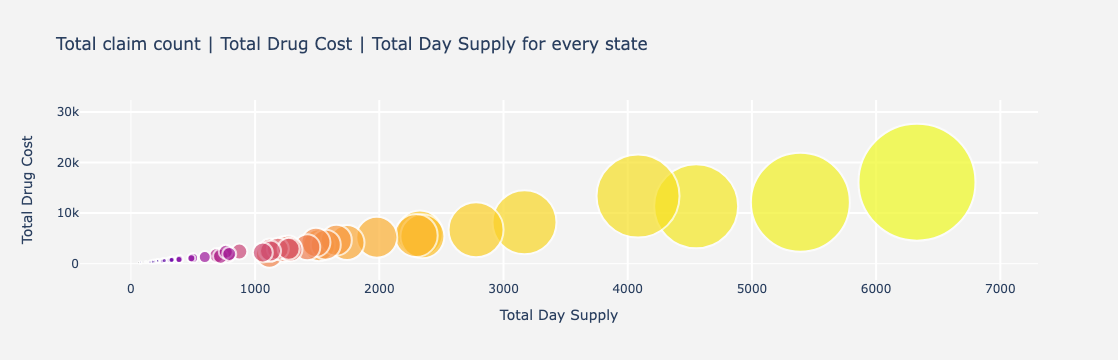

In [80]:
trace1 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    text=text,
    marker=dict(
        color=list(reversed([i*11 for i in range(200,251)])),
        size=size,
        line=dict(width=2),
    )
)
data = [trace1]

layout = go.Layout(
    title='Total claim count | Total Drug Cost | Total Day Supply for every state',
    xaxis=dict(
        title='Total Day Supply',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Total Drug Cost',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-colorscale')

In [88]:
most_pres_drug = (df.groupBy("Gnrc_Name")
             .agg(round(sum("Tot_Clms") / 1e6, 0).alias("total_claim_count_millions"),
                  round(sum("Tot_Day_Suply") / 1e6, 0).alias("total_day_supply_millions"),
                  round(sum("Tot_Drug_Cst") / 1e6, 0).alias("total_drug_cost_millions"),
                  max("Tot_Clms").alias("max_claim"),
                  max("Tot_Day_Suply").alias("max_day"),
                  max("Tot_Drug_Cst").alias("max_cost"),
                  variance("Tot_Clms").alias("var_claim"),
                  variance("Tot_Day_Suply").alias("var_day"),
                  variance("Tot_Drug_Cst").alias("var_cost"))
             .orderBy(col("total_claim_count_millions").desc()))

most_pres_drug.show()

+--------------------+--------------------------+-------------------------+------------------------+---------+-------+----------+------------------+--------------------+--------------------+
|           Gnrc_Name|total_claim_count_millions|total_day_supply_millions|total_drug_cost_millions|max_claim|max_day|  max_cost|         var_claim|             var_day|            var_cost|
+--------------------+--------------------------+-------------------------+------------------------+---------+-------+----------+------------------+--------------------+--------------------+
|Atorvastatin Calcium|                      60.0|                   4323.0|                   832.0|    13012| 411440| 302960.82|52295.697183003285|2.5703592099930927E8| 1.161384823365934E7|
|Levothyroxine Sodium|                      44.0|                   2905.0|                  1046.0|     6562| 245826| 311860.18| 24981.75014470423| 9.620598929661308E7|1.7470103551330738E7|
| Amlodipine Besylate|                      4

In [89]:
top_50_most_pres_drug = most_pres_drug.limit(50)
top_50_data = top_50_most_pres_drug.collect()


In [90]:
drug_names = [row['Gnrc_Name'] for row in top_50_data]
total_claims = [row['total_claim_count_millions'] for row in top_50_data]
total_day_supply = [row['total_day_supply_millions'] for row in top_50_data]
total_drug_cost = [row['total_drug_cost_millions'] for row in top_50_data]


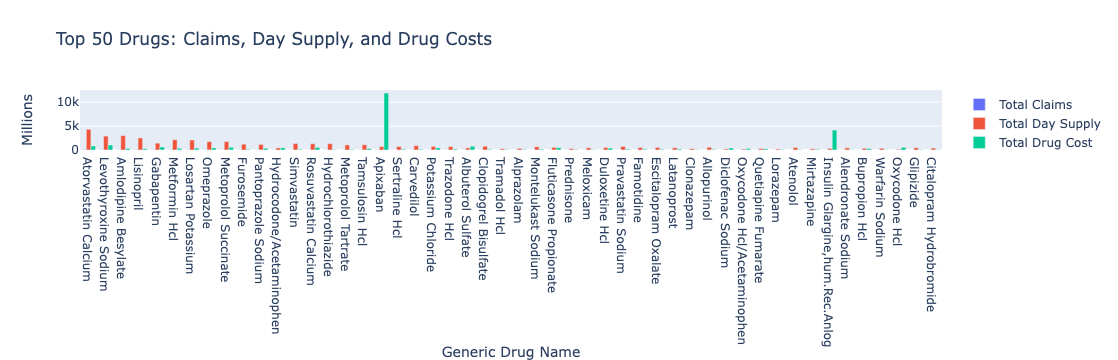

In [91]:
trace1 = go.Bar(
    x=drug_names,
    y=total_claims,
    name='Total Claims'
)
trace2 = go.Bar(
    x=drug_names,
    y=total_day_supply,
    name='Total Day Supply'
)
trace3 = go.Bar(
    x=drug_names,
    y=total_drug_cost,
    name='Total Drug Cost'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    margin=dict(b=200),  # Adjust bottom margin to prevent labels from being cut off
    title='Top 50 Drugs: Claims, Day Supply, and Drug Costs',
    xaxis=dict(title='Generic Drug Name'),
    yaxis=dict(title='Millions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')